In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch

In [8]:
def getBorderColor(img):
    
    border = np.asarray(img[0,:])
    border = np.concatenate((border, np.asarray(img[-1, :])))
    border = np.concatenate((border, np.asarray(img[:, 0])))
    border = np.concatenate((border, np.asarray(img[:, -1])))
    return np.bincount(border).argmax()


def pre_processing(img):
    _, img_binarized = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
    showImage(img_binarized)   
    if(getBorderColor(img_binarized) != 0):
        img_binarized = cv2.bitwise_not(img_binarized) 
    showImage(img_binarized)
    kernel = np.ones((30,30), np.uint8)
    img_dilation = cv2.dilate(img_binarized, kernel, iterations=1)
    cnts = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    cntsSorted = sorted(cnts, key=lambda x: cv2.contourArea(x), reverse=True)
    (x,y,w,h) = cv2.boundingRect(cntsSorted[0])
    return img_binarized[y:y+h, x:x+w]    

def showImage(img):
    plt.imshow(img, cmap='gray')
    plt.show()    


In [3]:
def getFeaturesHOG(img):
   img = cv2.resize(img, (256, 128))
   cell_size = (32, 32)  # h x w in pixels
   block_size = (2, 2)  # h x w in cells
   nbins = 9  # number of orientation bins
   # winSize is the size of the image cropped to an multiple of the cell size
   hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                    img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

   hog_feats = hog.compute(img)
   return hog_feats.flatten()  



In [73]:
def getFeaturesVP(img):
    img = cv2.Canny(img, 100, 200)
    # wihch is about 10% of image height
    MIN_LINE_PIXELS = int(0.10 * img.shape[0])
    lines = cv2.HoughLinesP(img, 1, np.pi/180, MIN_LINE_PIXELS, None, MIN_LINE_PIXELS, 0)
    v_lines_lengths = []
    h_lines_lengths = []
    
    if lines is not None:
            for line in lines:
                x1,y1,x2,y2 = line[0]
                cv2.line(img,(x1,y1),(x2,y2),20,2)
                # vertical lines
                if x1 == x2:
                    v_lines_lengths.append(abs(y2-y1))
                # horizontal    
                elif y1 == y2:
                    h_lines_lengths.append(abs(x2-x1))

    v_lines_lengths = np.asarray(v_lines_lengths)
    h_lines_lengths = np.asarray(h_lines_lengths)  
    
    v_lines_count = v_lines_lengths.shape[0]
    h_lines_count = h_lines_lengths.shape[0]
    
    # normalize heights of the vertical lines with respect to image height
    v_lines_lengths = v_lines_lengths/img.shape[0]

    if v_lines_count:
        LVL = max(v_lines_lengths)
        avg_v_line = np.mean(v_lines_lengths)
        LVL_diff_avg = LVL - avg_v_line
        variance_v_lines = np.var(v_lines_lengths)
    else:
        LVL = 0
        avg_v_line = 0
        LVL_diff_avg = 0
        variance_v_lines = 0
    return [v_lines_count, h_lines_count, LVL, avg_v_line, LVL_diff_avg, variance_v_lines]


# Read Data, Split Training, Validation, Test

In [4]:
data_set = []
Y = []
for i in range(1, 10):
    for filename in os.listdir("ACdata_base/" + str(i)):
        img = cv2.imread(os.path.join("ACdata_base/" + str(i),filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            data_set.append(img)
            Y.append(i)
            
X_train, X_testValid, Y_train, Y_testValid = train_test_split(data_set, Y, test_size=0.4, random_state=42)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_testValid, Y_testValid, test_size=0.5, random_state=42)            

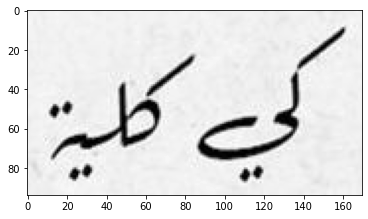

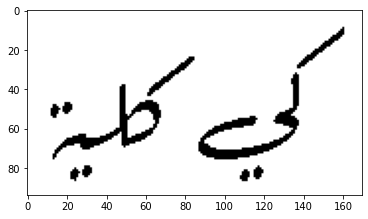

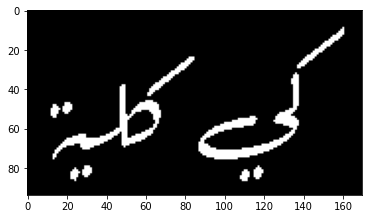

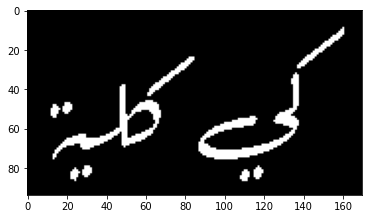

In [13]:
img = data_set[710]
showImage(img)
showImage(pre_processing(img))

In [69]:
lines_features = []
for i in range(len(data_set)):
    lines_features.append(getFeaturesVP(data_set[i])) 
#print(len(f1))


In [59]:
def getFeatures(images):
   x_features = []
   for i in range(len(images)):
        x_features.append(getFeaturesHOG(images[i]))
   return np.asarray(x_features)

In [62]:
train_features = getFeatures(X_train)
# test_valid_features = getFeatures(X_testValid)
# print(test_valid_features.shape)
# print(len(Y_testValid))

validation_features = getFeatures(X_validation)
test_features = getFeatures(X_test)

print(train_features.shape)
print(len(Y_train))

print(validation_features.shape)
print(len(Y_validation))

print(test_features.shape)
print(len(Y_test))



(1011, 756)
1011
(337, 756)
337
(337, 756)
337


In [57]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
X = np.array(train_features)
y = np.array(Y_train)
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [58]:
y_pred = (clf.predict(test_features))
#print(Y_validation)
acc = np.mean(y_pred == Y_testValid) * 100
print(acc)

90.50445103857567


In [38]:
from sklearn.ensemble import RandomForestClassifier
X = np.array(train_features)
y = np.array(Y_train)

for i in range(1, 100, 1):
    clf = RandomForestClassifier(max_depth=None, random_state=None)
    clf.fit(X, y)
    y_pred = (clf.predict(test_features))
    #print(Y_validation)
    acc = np.mean(y_pred == Y_testValid) * 100
    print("i = ", i, "accuracy = ", acc)


i =  1 accuracy =  87.53709198813057
i =  2 accuracy =  85.7566765578635
i =  3 accuracy =  85.7566765578635
i =  4 accuracy =  84.86646884272997
i =  5 accuracy =  87.53709198813057
i =  6 accuracy =  85.16320474777447
i =  7 accuracy =  86.35014836795251
i =  8 accuracy =  86.35014836795251


KeyboardInterrupt: 

In [31]:
#print(clf.predict(test_valid_features))


84.27299703264094


In [63]:
# H is hidden dimension; D_out is output dimension.
N, D_in, H1, D_out = train_features.shape[0], train_features.shape[1], 512, 9

x = torch.tensor(train_features).double()
y = torch.tensor(Y_train)
y = y-1 #output layer nodes indices [0:8] not [1:9]

x_validation = torch.tensor(validation_features).double()
Y_validation = torch.tensor(Y_validation)
Y_validation = Y_validation - 1

x_test = torch.tensor(test_features).double()
y_test = torch.tensor(Y_test)
y_test = y_test - 1

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, D_out),
    torch.nn.LogSoftmax(dim=1)
)

loss_fn = torch.nn.NLLLoss()

learning_rate = 5*1e-5


model.to(device)
model.double()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
validation_losses = []

In [65]:
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

for t in range(2000):

    #print(t)
    x = x.to(device)
    y = y.to(device)
    
    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item(),"  [Training]")
        training_losses.append(loss.item())
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 100 == 99:
        with torch.no_grad():
            x_valid = x_validation.to(device)
            y_valid = Y_validation.to(device)
            y_pred2 = model(x_valid)
            loss = loss_fn(y_pred2, y_valid)
            print(t, loss.item(),"  [Validation]" )
            validation_losses.append(loss.item())


99 1.7689537706403737   [Training]
99 1.759685918655571   [Validation]
199 1.327477093795606   [Training]
199 1.333261364127538   [Validation]
299 0.9857554689137276   [Training]
299 1.0227676811559785   [Validation]
399 0.7434131394079125   [Training]
399 0.810105798708039   [Validation]
499 0.5785379709367867   [Training]
499 0.6697886877501312   [Validation]
599 0.46451216207260854   [Training]
599 0.5756783626624902   [Validation]
699 0.38308739122308094   [Training]
699 0.5111010623001769   [Validation]
799 0.3223109190432314   [Training]
799 0.46527037411351474   [Validation]
899 0.2748759651199026   [Training]
899 0.4315808665028065   [Validation]
999 0.2364788649170691   [Training]
999 0.4061958497107574   [Validation]
1099 0.20455282424554408   [Training]
1099 0.38665651011159025   [Validation]
1199 0.1774693499001572   [Training]
1199 0.37149900326083685   [Validation]
1299 0.15420708150557066   [Training]
1299 0.3596276417786425   [Validation]
1399 0.13409133429313808   [Tra

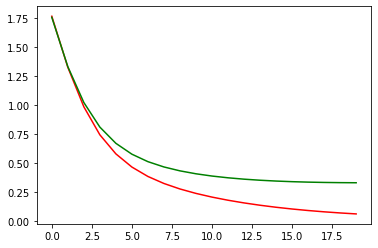

In [66]:
plt.plot(training_losses, '-r')
plt.plot(validation_losses, '-g')
plt.show()         

In [67]:
with torch.no_grad():
    y_pred = model(x)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y).item() / len(y)) * 100
    print("Training Accuracy = ", acc, "%")    

    x_valid = x_validation.to(device)
    y_valid = Y_validation.to(device)
    y_pred = model(x_valid)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y_valid).item() / len(y_valid)) * 100
    print("Validation Accuracy = ", acc, "%")

    x_test = x_test.to(device)
    y_test = y_test.to(device)

    y_pred = model(x_test)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y_test).item() / len(y_test)) * 100
    print("Test Accuracy = ", acc, "%")

Training Accuracy =  99.80217606330366 %
Validation Accuracy =  89.31750741839762 %
Test Accuracy =  91.3946587537092 %
